In [154]:
import sys
sys.path.append("/Users/octavia/Dropbox/SVE_v2/utilities")
sys.path.append("/Users/octavia/Dropbox/SVE_v2/model")
sys.path.append('/Users/octavia/Dropbox/SVE_v2/GW_model')

infl_modules = ['philips_infl', 'connect_SVE', 'GA_infl']
modules = ['search_functions', 'plot_functions', 'load_model_output',
           'gw_functions', 'SVE_mass_check']

for mod in modules + infl_modules:
    if mod in sys.modules: 
        del sys.modules[mod]

from load_model_output import *

from gw_functions import *
from plot_functions import *

from philips_infl import *
from connect_SVE import *

In [155]:
project_dir = "/Users/octavia/Dropbox/SVE_v2/"
base_name = "test_GW_phil"
base_dir = project_dir  + 'model_output/' + base_name 

print_input_params(base_dir)

batch:
	Ao : 0.0, 0.0001, 0.00025
sim:
	Ks : 0.0, 0.1, 1.0, 2.0, 3.0
	So : 0.01, 0.1
common:
	H_i : 0


In [156]:
core = load_sims(base_dir)
core[['So', 'Ks']]
# core = patchy_update(core)

,So,Ks
"Ao-0.0001/Ks-0.1,So-0.1/",0.1,0.1
"Ao-0.0001/Ks-2.0,So-0.01/",0.01,2
"Ao-0.0001/Ks-2.0,So-0.1/",0.1,2
"Ao-0.0001/Ks-3.0,So-0.1/",0.1,3
"Ao-0.0001/Ks-3.0,So-0.01/",0.01,3
"Ao-0.0001/Ks-0.1,So-0.01/",0.01,0.1
"Ao-0.0001/Ks-1.0,So-0.1/",0.1,1
"Ao-0.0001/Ks-0.0,So-0.1/",0.1,0
"Ao-0.0001/Ks-0.0,So-0.01/",0.01,0
"Ao-0.0001/Ks-1.0,So-0.01/",0.01,1


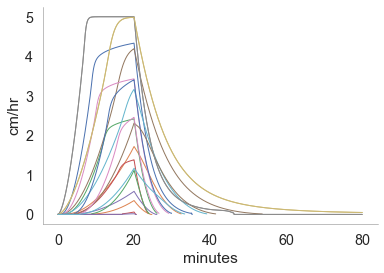

In [129]:
fig = plot_hydrographs(core)
core = core[core.Ks > 0]

In [164]:
sim =core.iloc[10]
sim = core.loc['Ao-0.00025/Ks-0.1,So-0.01/']
param = get_GW_param(sim)
res = Comparison_function2(param)
res = pd.Series(res)
sim.name


'Ao-0.00025/Ks-0.1,So-0.01/'

In [165]:
iparam = get_philip_param(sim)

philips_i =  compute_philip_infl(iparam)


(0, 5.250004199999999)

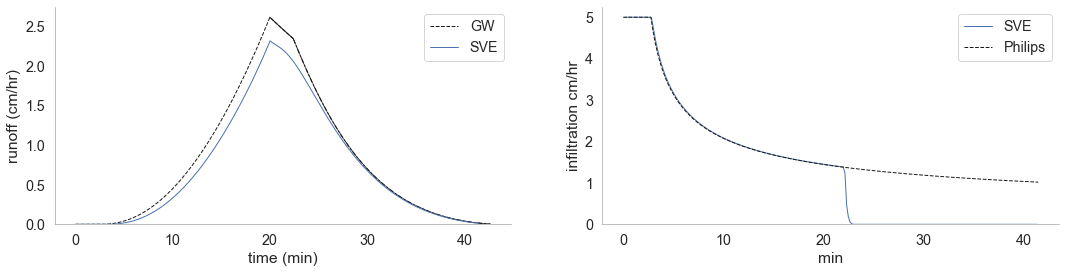

In [166]:

fig, axes = plt.subplots(1, 2, figsize = (18, 4))
ax = axes[0]
ax.plot(res.t/60, res.q/res.L*3.6e5, 'k--', label = "GW")
ax.plot(res.t_d2/60, res.q_d2/res.L*3.6e5, 'k-')
ax.plot(res.t_d3/60, res.q_d3/res.L*3.6e5, 'k-.')
plt.xlabel("min")
ax.set_ylim(0, )
ax.plot(sim.t_h/60, sim.flux3/sim.area*3.6e5, '-', label = "SVE")
ax.legend()
ax.set_ylabel("runoff (cm/hr)")
ax.set_xlabel("time (min)")

ax = axes[1]
ax.plot(sim.t_print[1:]/60, sim.infl_3d[1:,0,0]*3.6e5, label = "SVE")
ax.plot(philips_i["t"]/60., philips_i["f"]*3.6e5, 'k--', label = "Philips")
ax.set_ylabel("infiltration cm/hr")
plt.xlabel("min")
plt.legend()
ax.set_ylim(0, )

(0, 0.005435323156924808)

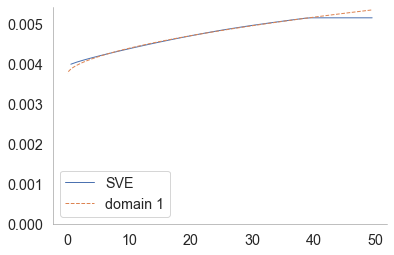

In [135]:
xf2 = res['x_f2']
tf2 = res['t_f2']
xf = res['x_f']
tf = res['t_f']
L = sim["Lx"]
fig, ax = plt.subplots(1)
ax.plot(sim.xc.mean(0), sim.infl_2d.mean(0), label = "SVE")
param = get_philip_param(sim)
if np.any(xf<L):
    I = compute_philip_F(param, tf[xf<L])
    ax.plot(xf[xf<L],  I , '--', label = "domain 1")
if np.any(xf2<L):
    I = compute_philip_F(param, tf2[xf2<L])
    ax.plot(xf2[xf2<L], I , '--', label = "domain 2")
ax.legend()
ax.set_ylim(0, )

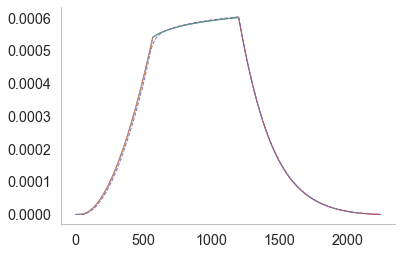

In [136]:
plt.plot(res['t'], res['q'])
plt.plot(res['t_d1'], res['q_d1'])
plt.plot(res['t_d2'], res['q_d2'])
plt.plot(res['t_d3'], res['q_d3'])

plt.plot(sim.t_h, sim.flux3/sim.Ly, '--')


In [137]:
from scipy import interpolate
def get_percent_diff(sim):
    """
    Compute SVE-Phil / GW comparisoin for all simulations
    """

    param = get_GW_param(sim)
    res = Comparison_function2(param)
    res = pd.Series(res)

    f = interpolate.interp1d(res.t, res.q)
    tmax = min(res.t[-1], sim.t_h[-1])
    tmin = max(res.t[0], sim.t_h[0])

    t_GW = sim.t_h[(sim.t_h<=tmax) & (sim.t_h >= tmin)]
    q_GW = f(t_GW)      #  m2/s


    q_SVE = sim.flux3[(sim.t_h<=tmax) & (sim.t_h >= tmin)]/sim.Ly  # m2/s

    hydro_percent_diff = np.zeros_like(q_SVE)
    inds =  np.where((q_GW > 0) &  (q_SVE > 0))[0]
    hydro_percent_diff[inds] = (q_SVE[inds] - q_GW[inds])
    hydro_percent_diff = hydro_percent_diff.mean()/q_GW[inds].mean()*100
    infl_frac_percent_diff = (sim.infl_frac - res.infl_frac)/sim.infl_frac*100

    return hydro_percent_diff, infl_frac_percent_diff


In [145]:
compare = {}
for key in core.index:
    sim = core.loc[key]
    if sim.hydro.mean() ==0.:
        continue
    else:
        compare[key] = {}
    compare[key]['p'] = core.loc[key]['p']
    compare[key]['Ao'] = core.loc[key]['Ao']
    compare[key]['So'] = core.loc[key]['So']*100   
    compare[key]['ksatV'] = core.loc[key]['ksatV']    
    hydro_percent_diff, IF_percent_diff =  get_percent_diff(core.loc[key])
    compare[key]['hydro_percent_diff'] = np.round(hydro_percent_diff, 2)
    compare[key]['IF_percent_diff']  = np.round(IF_percent_diff, 2)
cols= [ 'p', 'So', 'KsV', 'hydro_percent_diff', 'IF_percent_diff']
compare = pd.DataFrame(compare).T

In [146]:
compare.sort_values([ "ksatV","So"])

,p,Ao,So,ksatV,hydro_percent_diff,IF_percent_diff
"Ao-0.0001/Ks-0.1,So-0.01/",5.0,0.00010,1.0,2.777778e-07,-1.08,1.83
"Ao-0.00025/Ks-0.1,So-0.01/",5.0,0.00025,1.0,2.777778e-07,-10.31,5.53
"Ao-0.0001/Ks-0.1,So-0.1/",5.0,0.00010,10.0,2.777778e-07,-0.59,1.99
"Ao-0.00025/Ks-0.1,So-0.1/",5.0,0.00025,10.0,2.777778e-07,-7.24,6.14
"Ao-0.0001/Ks-1.0,So-0.01/",5.0,0.00010,1.0,2.777778e-06,-1.85,1.15
"Ao-0.00025/Ks-1.0,So-0.01/",5.0,0.00025,1.0,2.777778e-06,-18.10,3.72
"Ao-0.0001/Ks-1.0,So-0.1/",5.0,0.00010,10.0,2.777778e-06,-0.91,1.25
"Ao-0.00025/Ks-1.0,So-0.1/",5.0,0.00025,10.0,2.777778e-06,-10.47,4.40
"Ao-0.0001/Ks-2.0,So-0.01/",5.0,0.00010,1.0,5.555556e-06,-3.69,0.85
"Ao-0.00025/Ks-2.0,So-0.01/",5.0,0.00025,1.0,5.555556e-06,-22.15,0.95


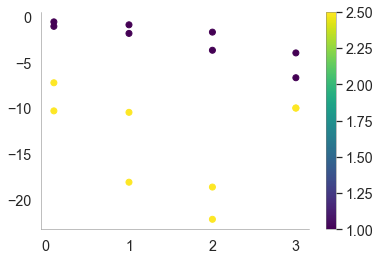

In [153]:
plt.scatter(compare["ksatV"]*3.6e5, compare["hydro_percent_diff"], c = compare["Ao"]*1e4, cmap = "viridis")
plt.colorbar()